<a href="https://colab.research.google.com/github/akalpit23/Interpretable-ML/blob/main/Assignment-4/Assignment_04_Interpretable_ML_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# AIPI 590 - XAI | Assignment #04



## Akalpit Dawkhar

### **Interpretable ML-2**

### Overview

The notebook presents an in-depth exploration of interpretable ML techniques applied to the diabetes dataset. It showcases the implementation and comparison of advanced interpretable models, including RuleFit, GreedyRuleListClassifier, APLR, and Greedy Tree Regressor. The notebook demonstrates a comprehensive approach to data preprocessing, model fitting, and result visualization, with a focus on extracting meaningful insights from the diabetes data. By leveraging these interpretable models, the notebook aims to provide clear, understandable predictions and rules, enhancing the transparency and explainability of machine learning outcomes in a real-world context.

# 1. Importing neccesarry libraries, loading and preprocessing the data.

In [4]:
# !pip install skope-rules shap lime scikit-learn seaborn skope-rules matplotlib setuptools six rulefit --upgrade
# !pip install --upgrade imodels
# !pip install interpret
# !pip install collections
# !pip show imodels graphviz


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import shap
import lime
import sklearn
import collections
import demo_helper
import six
import os
import graphviz
collections.Iterable = collections.abc.Iterable
sklearn.externals.six = six
from scipy.io import arff
from sklearn.metrics import confusion_matrix, roc_curve, auc, accuracy_score, precision_recall_curve, classification_report
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler ,OneHotEncoder, label_binarize, KBinsDiscretizer
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, precision_recall_curve, roc_auc_score
from sklearn.datasets import load_diabetes
from sklearn.ensemble import BaggingClassifier, BaggingRegressor
from sklearn import tree
from itertools import cycle
import skrules.skope_rules
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
import six
from imodels import  RuleFitRegressor, BoostedRulesClassifier, GreedyRuleListClassifier, GreedyTreeClassifier, GreedyTreeRegressor
from rulefit import RuleFit
from skrules import SkopeRules
from skrules import SkopeRules as SkopeRulesClassifier
from interpret.glassbox import ExplainableBoostingClassifier
from interpret import set_visualize_provider
from interpret.provider import InlineProvider
set_visualize_provider(InlineProvider())
from interpret.glassbox import APLRClassifier
from interpret import show


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [28]:
# Please use this to connect your GitHub repository to your Google Colab notebook
# Connects to any needed files from GitHub and Google Drive
import os

# Remove Colab default sample_data
!rm -r ./sample_data

# Clone GitHub files to colab workspace
repo_name = "Interpretable-ML" # Change to your repo name
git_path = 'https://github.com/akalpit23/Interpretable-ML/Assignment-4.git' #Change to your path
!git clone "{git_path}"

# Install dependencies from requirements.txt file
#!pip install -r "{os.path.join(repo_name,'requirements.txt')}" #Add if using requirements.txt

# Change working directory to location of notebook
notebook_dir = 'Assignment_04_Interpretable_ML_2.ipynb'
path_to_notebook = os.path.join(repo_name,notebook_dir)
%cd "{path_to_notebook}"
%ls


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



Cloning into 'Assignment-4'...
remote: Not Found
fatal: repository 'https://github.com/akalpit23/Interpretable-ML/Assignment-4.git/' not found
[Errno 2] No such file or directory: 'Interpretable-ML/Assignment_04_Interpretable_ML_2.ipynb'
/content
demo_helper.py  __pycache__/


### Creating and applying monkey patches

In [6]:
def patched_init(*args, **kwargs):
    """
    Patched __init__ method for BaggingClassifier in the skrules.skope_rules module.

    This patch modifies the constructor (__init__) of the BaggingClassifier class to ensure
    compatibility with updated scikit-learn or model APIs. Specifically, it renames the
    'base_estimator' argument to 'estimator', as some versions of libraries may expect
    'estimator' instead of 'base_estimator'.

    Parameters:
    *args: tuple
        Positional arguments that are passed to the original __init__ method of
        BaggingClassifier.

    **kwargs: dict
        Keyword arguments that are passed to the original __init__ method of
        BaggingClassifier. If 'base_estimator' is provided, it is renamed to 'estimator'
        before passing to the original __init__ method.

    Returns:
    object
        The initialized BaggingClassifier object after calling the original __init__
        with modified arguments, if applicable.

    Notes:
    ------
    This patch is useful for maintaining backward compatibility with older versions of
    code or when there is a naming conflict in the API. It modifies the constructor at
    runtime without directly altering the source code of the `imodels` or `skrules` library.
    """
    if 'base_estimator' in kwargs:
        kwargs['estimator'] = kwargs.pop('base_estimator')
    return original_init(*args, **kwargs)

original_init = skrules.skope_rules.BaggingClassifier.__init__
skrules.skope_rules.BaggingClassifier.__init__ = patched_init

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [7]:
def patch_estimator(cls):
    """
    Patched initialization method for BaggingClassifier in the skrules.skope_rules module.

    This function modifies the '__init__' method of the BaggingClassifier class to replace
    the 'base_estimator' keyword argument with 'estimator' to maintain compatibility
    with updated API changes or requirements in the 'skrules.skope_rules' package.

    Parameters:
    *args: tuple
        Positional arguments passed to the original __init__ method of BaggingClassifier.

    **kwargs: dict
        Keyword arguments passed to the original __init__ method of BaggingClassifier.
        If 'base_estimator' is present in the kwargs, it is replaced with 'estimator'.

    Returns:
    The result of calling the original __init__ method of BaggingClassifier with modified
    arguments and keyword arguments.

    Notes:
    This patch is necessary because some versions of scikit-learn and other model
    implementations may use 'estimator' instead of 'base_estimator'. This ensures
    compatibility without modifying the underlying library directly.
    """
    original_init = cls.__init__
    def patched_init(*args, **kwargs):
        if 'base_estimator' in kwargs:
            kwargs['estimator'] = kwargs.pop('base_estimator')
        return original_init(*args, **kwargs)
    cls.__init__ = patched_init

patch_estimator(skrules.skope_rules.BaggingClassifier)
patch_estimator(skrules.skope_rules.BaggingRegressor)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### Loading and pre-processing the data

In [8]:
# Load the diabetes dataset
diabetes = load_diabetes()

# Convert the continuous target to binary
y_median = np.median(diabetes.target)
y = (diabetes.target > y_median).astype(int)  # labels 0-1

# Prepare the feature data
X = diabetes.data.astype('float32')

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.75)  # split


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [9]:
# Convert to DataFrame
diabetes_df = pd.DataFrame(data=diabetes.data, columns=diabetes.feature_names)

# Print the first 5 rows
print(diabetes_df.head())

# Get the feature names
f_names = diabetes.feature_names

# Define the original feature names
o_names = ["age", "sex", "bmi", "bp", "tc", "ldl", "hdl", "tch", "ltg", "glu"]

        age       sex       bmi        bp        s1        s2        s3  \
0  0.038076  0.050680  0.061696  0.021872 -0.044223 -0.034821 -0.043401   
1 -0.001882 -0.044642 -0.051474 -0.026328 -0.008449 -0.019163  0.074412   
2  0.085299  0.050680  0.044451 -0.005670 -0.045599 -0.034194 -0.032356   
3 -0.089063 -0.044642 -0.011595 -0.036656  0.012191  0.024991 -0.036038   
4  0.005383 -0.044642 -0.036385  0.021872  0.003935  0.015596  0.008142   

         s4        s5        s6  
0 -0.002592  0.019907 -0.017646  
1 -0.039493 -0.068332 -0.092204  
2 -0.002592  0.002861 -0.025930  
3  0.034309  0.022688 -0.009362  
4 -0.002592 -0.031988 -0.046641  


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [10]:
# Check the shape of your DataFrame
print(X_train.shape)

# Check the column names of your DataFrame
print(diabetes_df.columns)

(110, 10)
Index(['age', 'sex', 'bmi', 'bp', 's1', 's2', 's3', 's4', 's5', 's6'], dtype='object')


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


# 2. RuleFit rule


  **Rule Generation:** RuleFit generates if-then decision rules from an ensemble of decision trees (e.g., Random Forests or Gradient Boosting).

  **Sparse Linear Model:** After generating the rules, RuleFit fits a sparse linear model where the input features are both the original features and the decision rules. The sparsity is enforced using regularization (like L1).

  **Interpretability:** The resulting model is interpretable because the decision rules are simple and human-readable, making it easy to understand how predictions are made.

In [11]:
# Initialize the RuleFitRegressor
rf = RuleFitRegressor(max_rules=10, memory_par=0.01, tree_size=4, lin_standardise=True)

# Fit the model to your data
rf.fit(X_train, y_train, feature_names=o_names)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


RuleFitRegressor(max_rules=10)

In [12]:
# Use the model to make predictions
predictions = rf.predict(X_test)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [13]:
rule_df = rf.visualize()
rule_df

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


rule  \
12                                                           bmi <= 0.00565 and bp <= 0.04654   
14                                       age > -0.04547 and hdl <= 0.06337 and ltg > -0.01093   
18                                       bmi > -0.00836 and hdl <= 0.06337 and ltg > -0.05118   
17                                                              bp > -0.016 and ltg > -0.0124   
13  age <= 0.06169 and bmi <= 0.02128 and bp <= 0.04482 and ldl > -0.05267 and glu <= 0.09212   
15                                         bp > -0.01772 and tc > -0.02083 and hdl <= 0.06337   
10                                        bmi <= 0.02182 and tc <= 0.05209 and ltg <= 0.01178   
16                                                          sex <= 0.00302 and ltg > -0.02032   
11                                         age > -0.08725 and bp <= -0.016 and glu <= 0.04034   

    coef  
12 -0.04  
14  0.15  
18  0.09  
17  0.05  
13 -0.05  
15  0.05  
10 -0.08  
16  0.06  
11 -0.02

In [14]:
# Inspect and print the rules
print('Rulefit visualization:')
rules = rf._get_rules()
rules = rules[rules.coef != 0].sort_values("support", ascending=False)
display(rules[['rule', 'coef', 'support']].style.background_gradient(cmap='Blues'))

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Rulefit visualization:


In [15]:
# Calculate the mean absolute error
mae = mean_absolute_error(y_test, predictions)

# Calculate the mean squared error
mse = mean_squared_error(y_test, predictions)

# Calculate the R-squared score
r2 = r2_score(y_test, predictions)

# Print the metrics
print(f'MAE: {mae}')
print(f'MSE: {mse}')
print(f'R2 Score: {r2}')

MAE: 0.40026102445583955
MSE: 0.19100151641244825
R2 Score: 0.23530016544819665


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


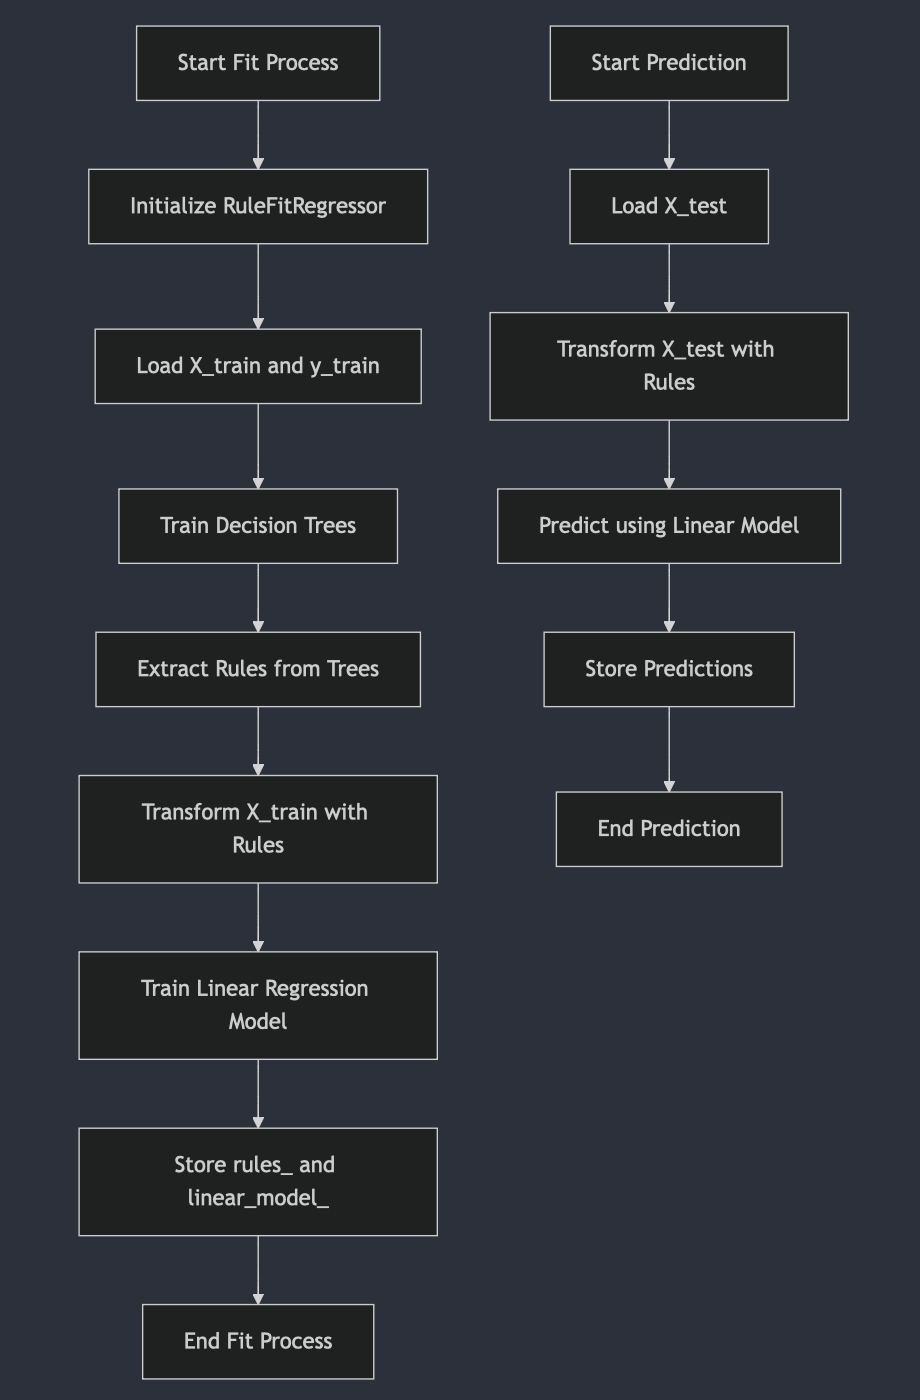

# 3. Greedy Rule List Classifier

**Rule-Based Model:** The classifier creates a list of if-then rules that are easy to understand. Each rule sequentially applies conditions to the input data, and when a condition is satisfied, a classification is made.

**Greedy Algorithm:** The model builds the rule list incrementally by selecting the best rule at each step according to a specified criterion, such as accuracy or coverage.

**Interpretable:** Due to its simplicity, the Greedy Rule List Classifier is highly interpretable, making it ideal for applications where understanding the model’s decision-making process is essential.


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


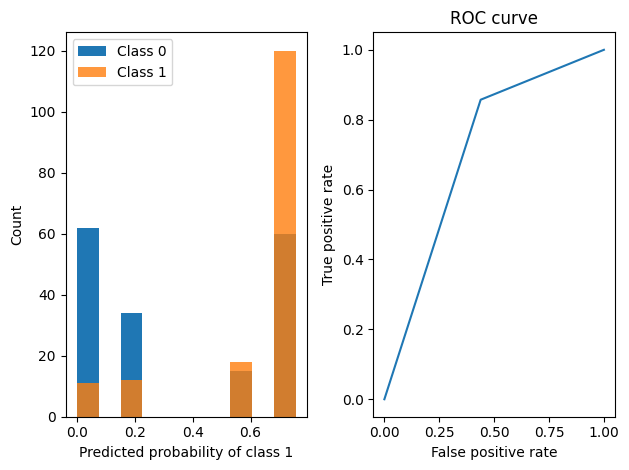

GreedyRuleListClassifier()

In [16]:
# fit a greedy rule list
greedy_model = GreedyRuleListClassifier()
greedy_model.fit(X_train, y_train, feature_names=o_names)  # stores into m.rules_
probability_grlc = greedy_model.predict_proba(X_test)

# look at prediction breakdown
demo_helper.viz_classification_preds(probability_grlc, y_test)

greedy_model

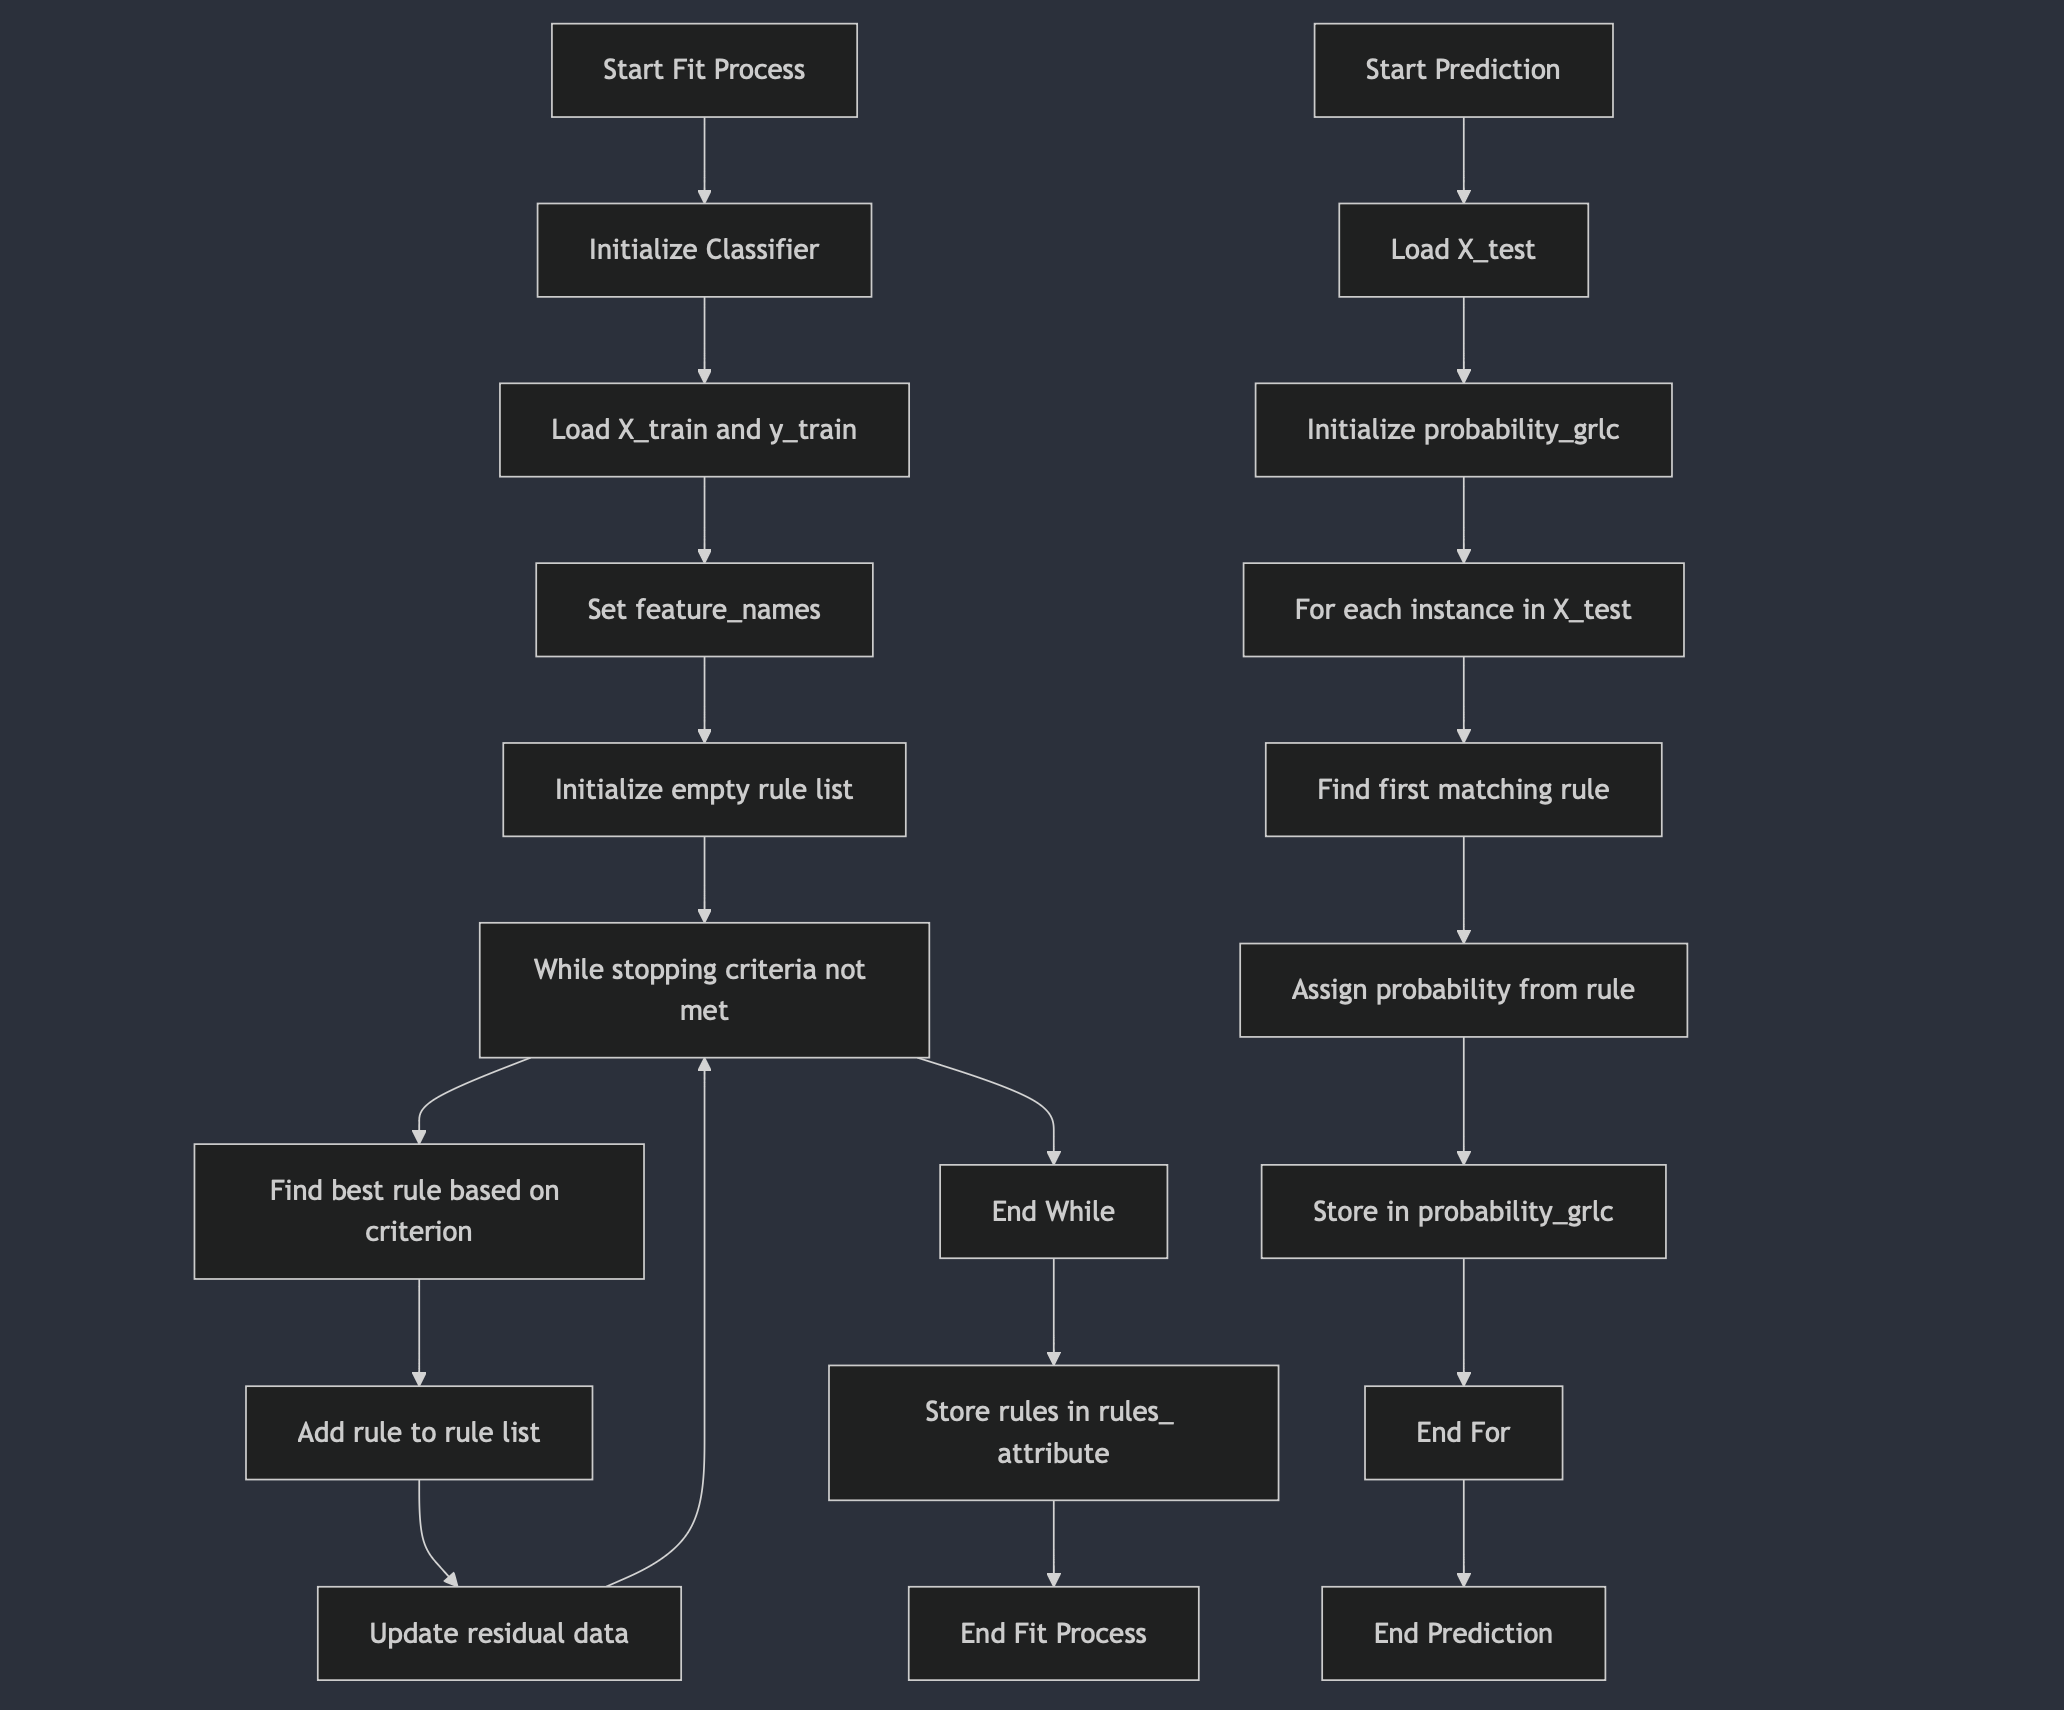

# 4. Automatic Piecewise Linear Regression (APLR) (Sub-section of Tree GAM)

**Piecewise Linear Functions:** APLR learns linear relationships for each feature in segments, making it more flexible in capturing non-linear interactions compared to simple linear regression.

**Interpretability:** The model maintains a high level of interpretability by allowing users to visualize how each feature influences the predictions through piecewise linear segments.

**Global and Local Explanations:** APLR can provide both global explanations (the overall relationship between features and the target) and local explanations (how individual features affect predictions for specific instances).


In [17]:
seed = 42
np.random.seed(seed)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=seed
)

aplr = APLRClassifier(random_state=seed)
aplr.fit(X_train, y_train, X_names=o_names)

auc = roc_auc_score(y_test, aplr.predict_class_probabilities(X_test)[:, 1])
print("AUC: {:.3f}".format(auc))

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


AUC: 0.826


In [18]:
show(aplr.explain_local(X_test[:5], y_test[:5]))

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


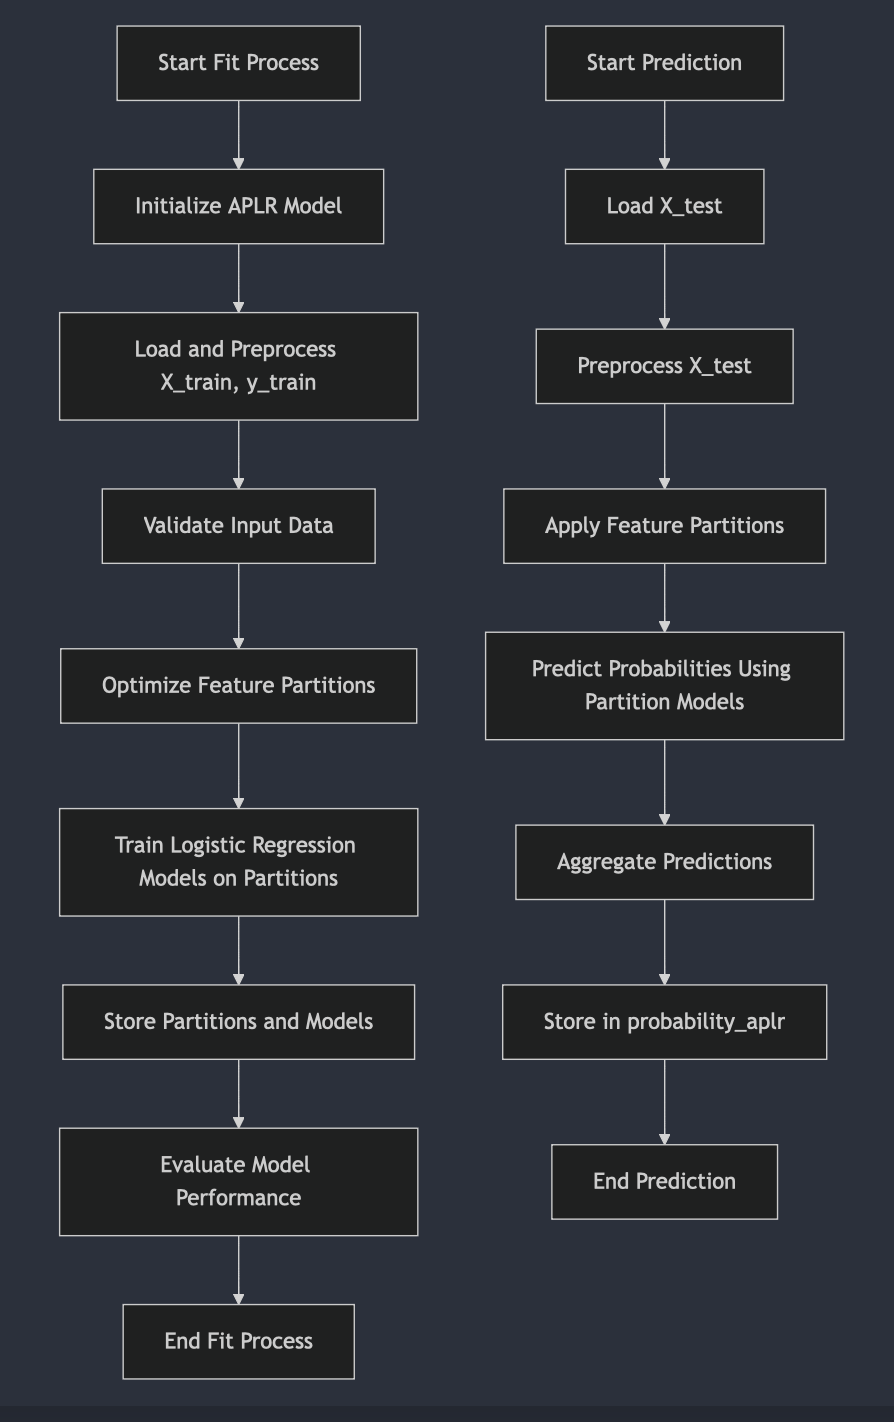

# 5. Greedy Tree Regressor

**Decision Tree Structure:** The model works by partitioning the feature space into regions based on decision rules (feature thresholds). Each leaf of the tree represents a predicted value (the average of target values in that region).

**Greedy Algorithm:** The regressor selects the optimal split for each node at each step by greedily minimizing the variance (or other cost function) in the target values. It does not reconsider past splits, which may lead to local optima.

**Interpretability:** Decision trees, including the Greedy Tree Regressor, are highly interpretable because the structure and rules of the tree can be visualized and understood easily by humans.


In [19]:
# Fit the model to the training data
gtr_model = GreedyTreeRegressor()
gtr_model.fit(X_train, y_train)

# Get the predictions
y_pred_gtr = gtr_model.predict(X_test)

# Calculate the accuracy
accuracy_greedytree = accuracy_score(y_test, y_pred_gtr)
print(f"GreedyTreeRegressor: {accuracy_greedytree}")

GreedyTreeRegressor: 0.6741573033707865


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



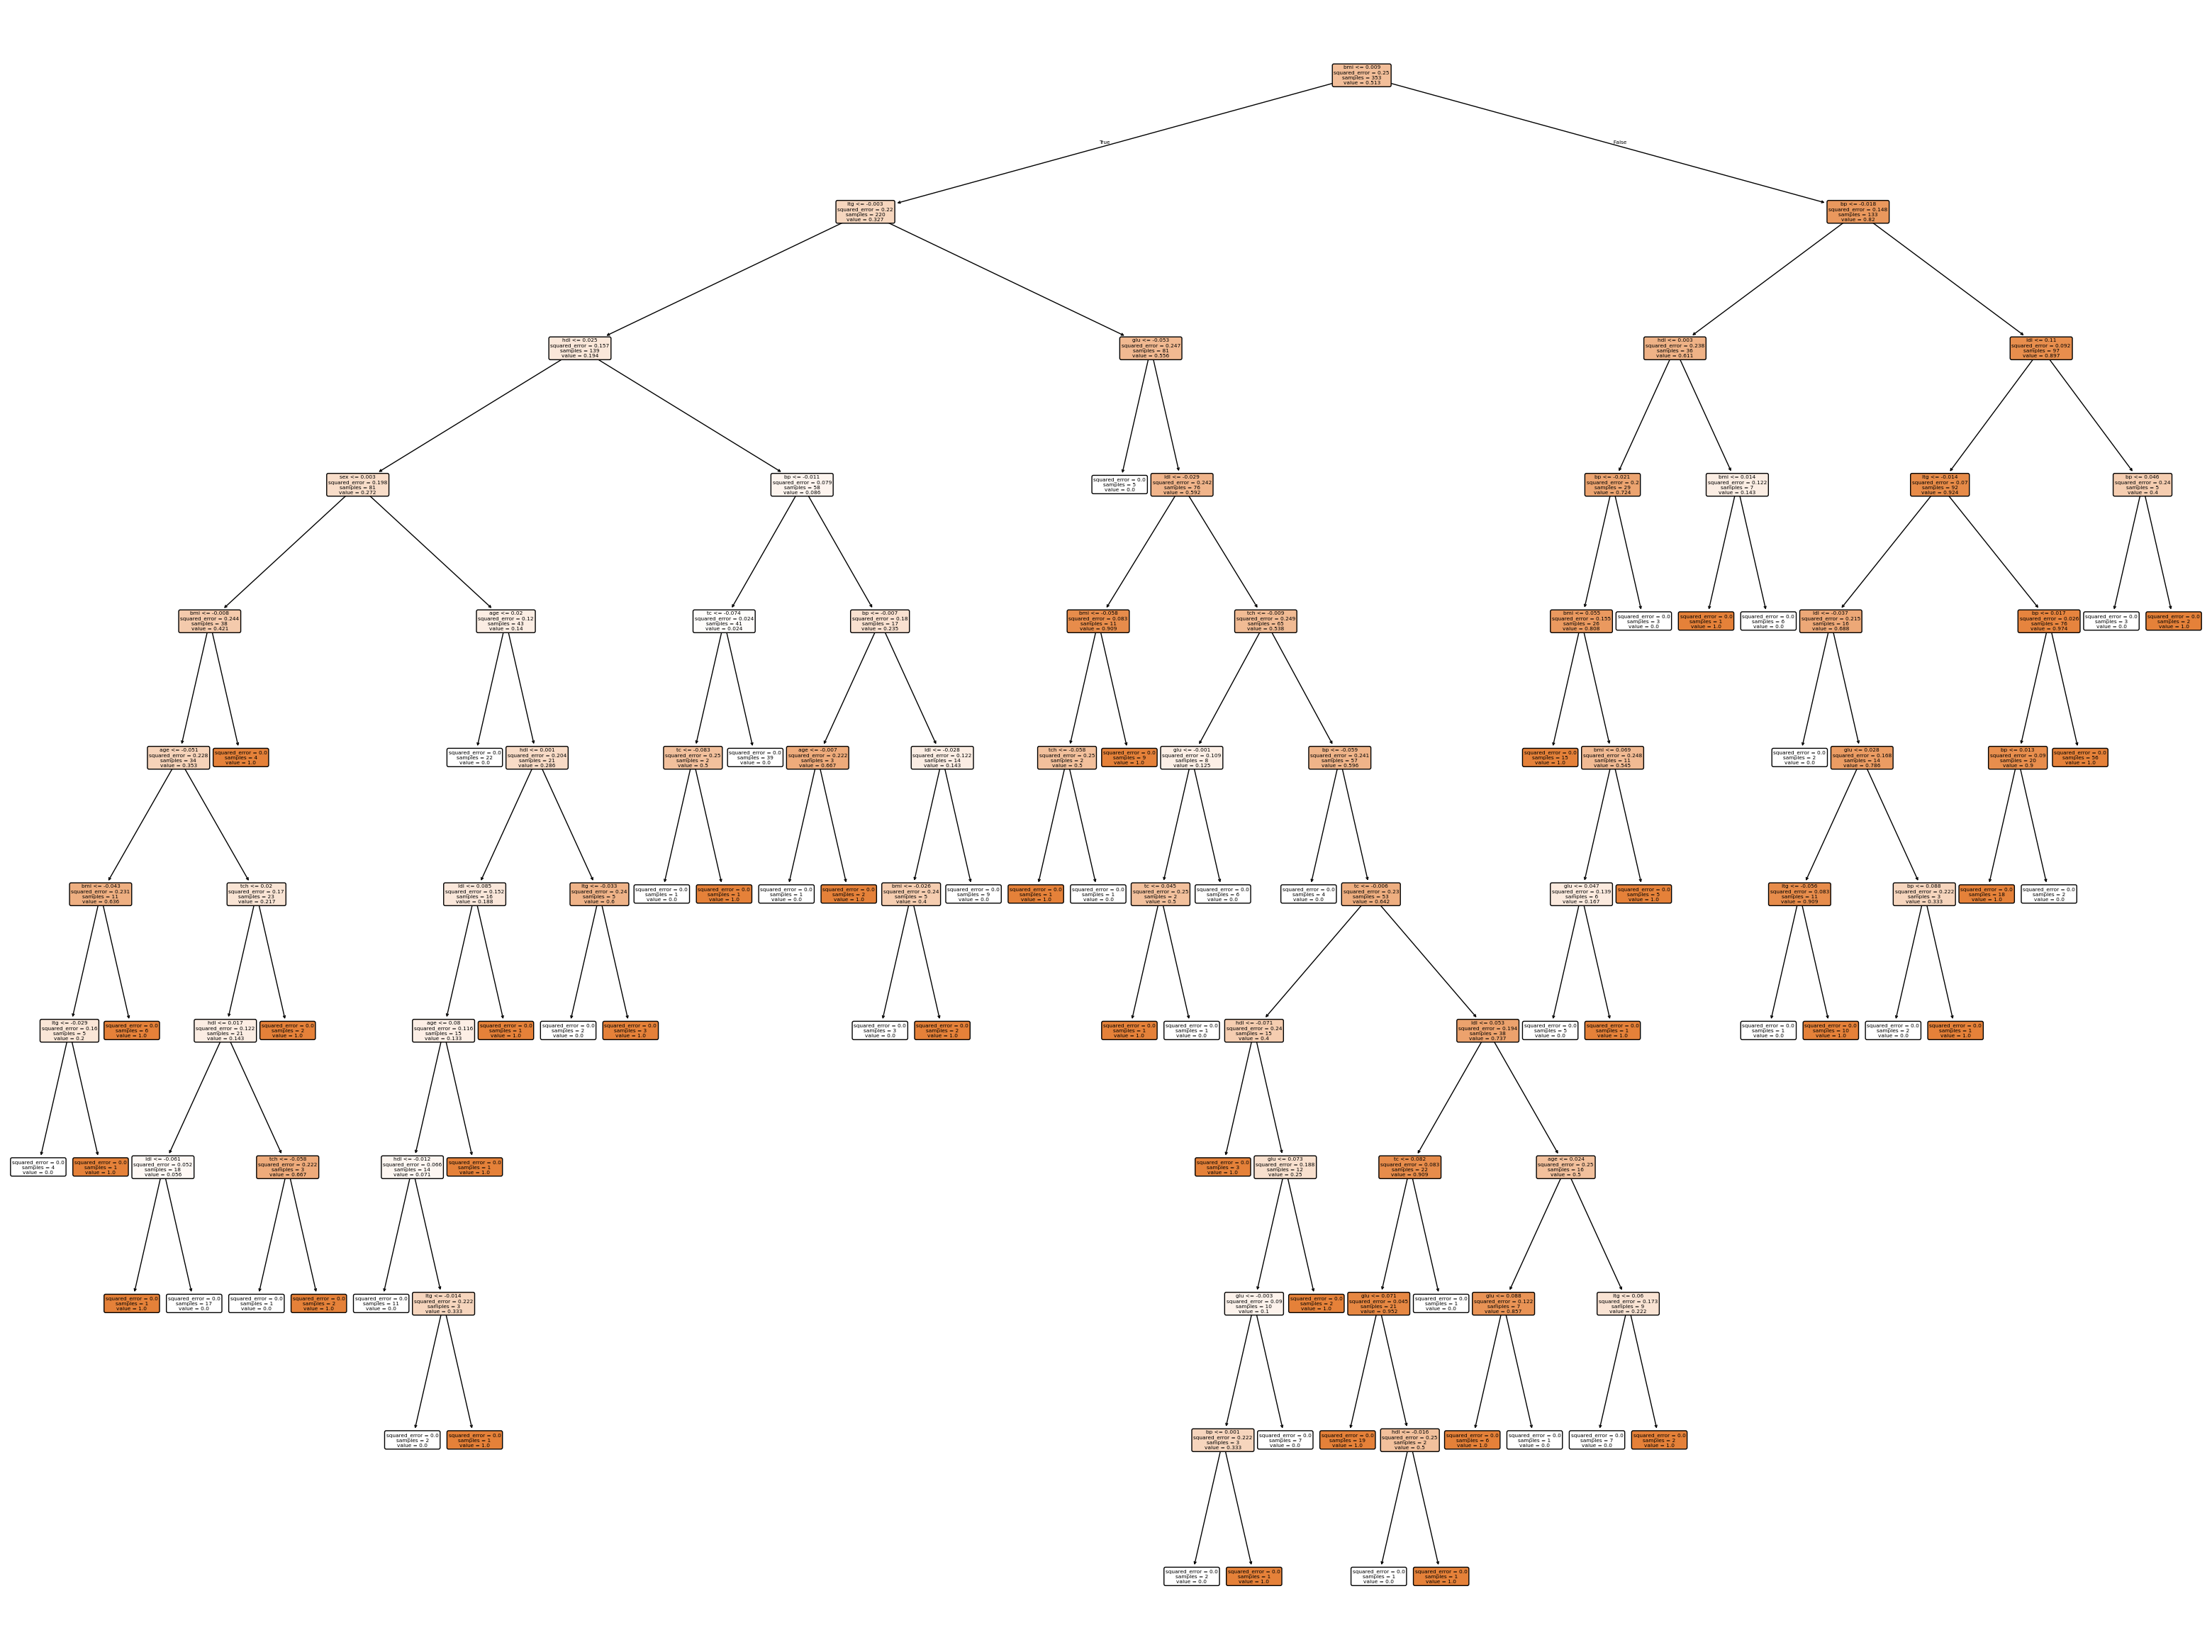

In [26]:
# Visualize the decision tree
plt.figure(figsize=(40, 30))
tree.plot_tree(gtr_model, feature_names=o_names, filled=True, rounded=True)
plt.show()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



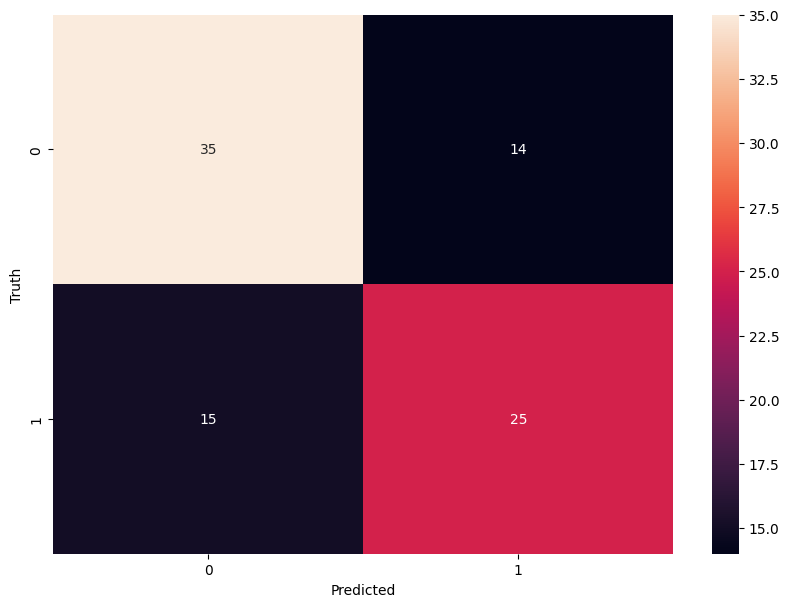

<Figure size 1000x700 with 0 Axes>

<Figure size 1000x700 with 0 Axes>

In [27]:
# Calculate the confusion matrix
cm = confusion_matrix(y_test, y_pred_gtr)

# Plot the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')
plt.show()

plt.figure(figsize=(10, 7))

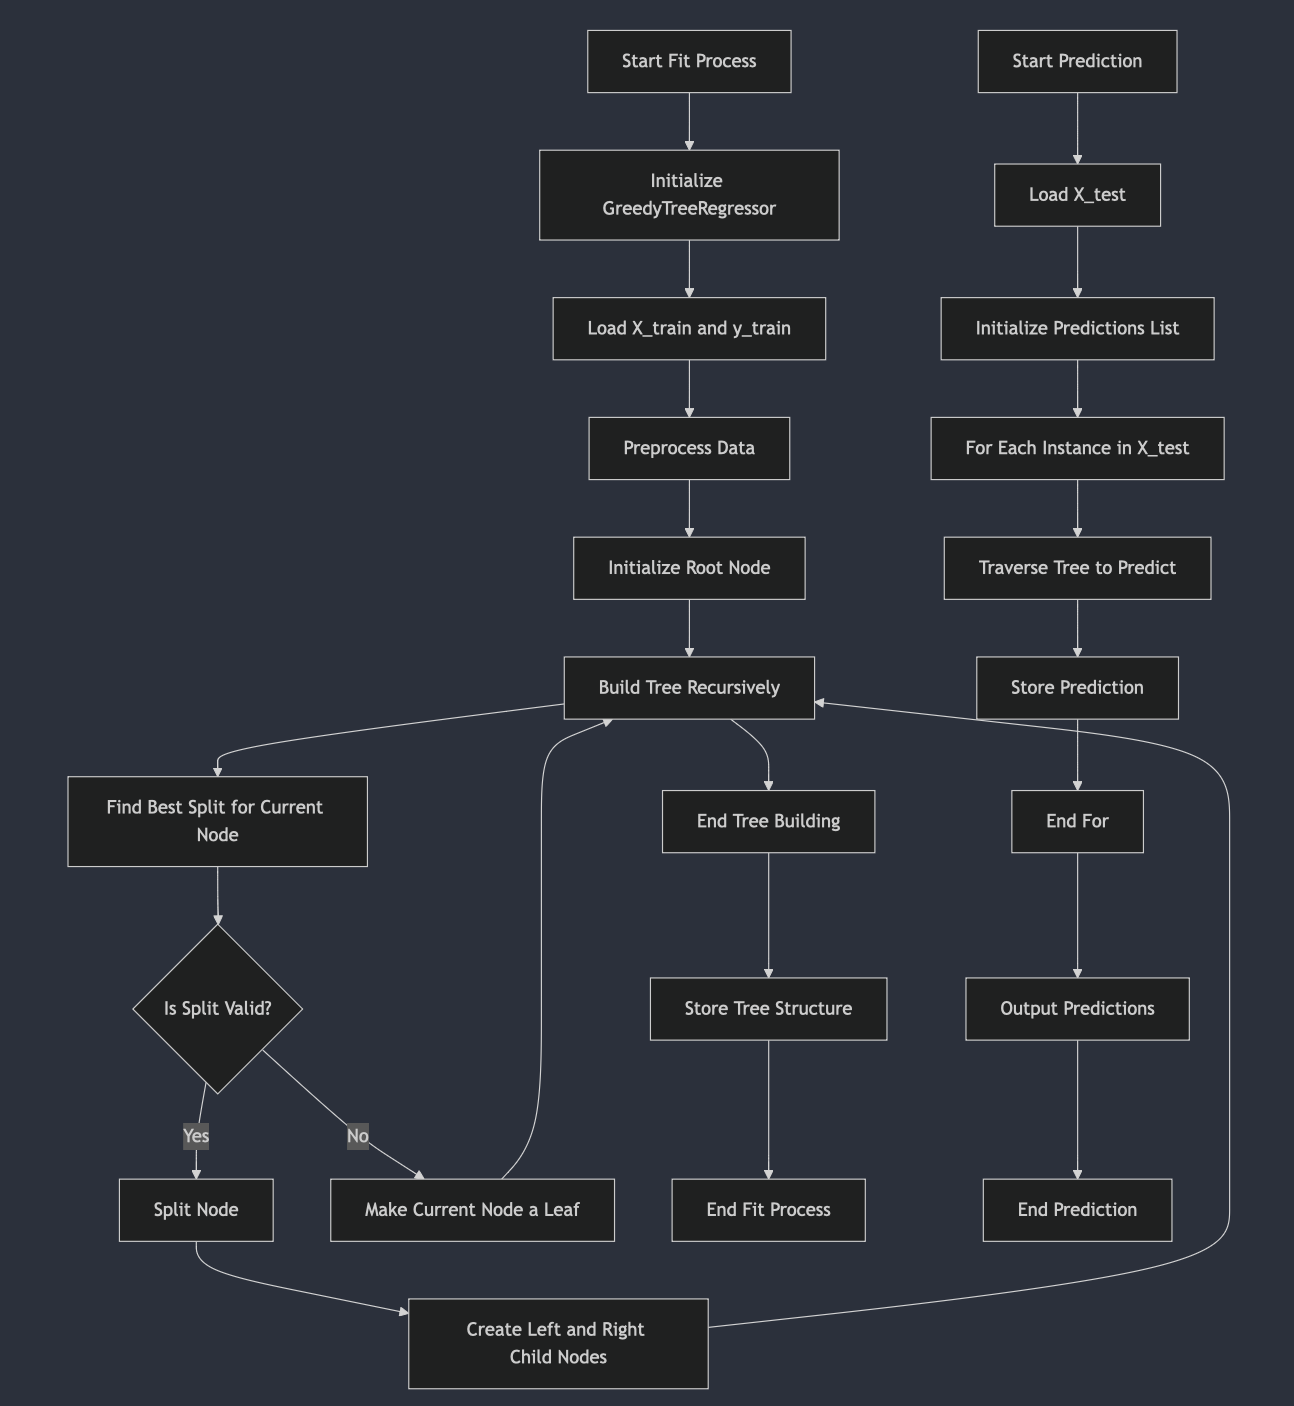

# 6. Conclusion:



1.   Of all the models worked on rulefit has a r2 score of 0.235 which is not a very satisfying performance metric.
2.   In terms of performance, APLR has the best output
3. In terms of interpretability greedy tree regressor and APLR do an extremely great job of explaining the model.





# 7. Refrences:


*   https://github.com/csinva/imodels/tree/master?tab=readme-ov-file
*   https://github.com/interpretml/interpret?tab=readme-ov-file
*   https://github.com/christophM/rulefit